In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [101]:
# 1. Load dữ liệu và xử lý thời gian
train_df = pd.read_csv("bnb_train.csv", parse_dates=['Date'], index_col='Date')
val_df = pd.read_csv("bnb_val.csv", parse_dates=['Date'], index_col='Date')
test_df = pd.read_csv("bnb_test.csv", parse_dates=['Date'], index_col='Date')


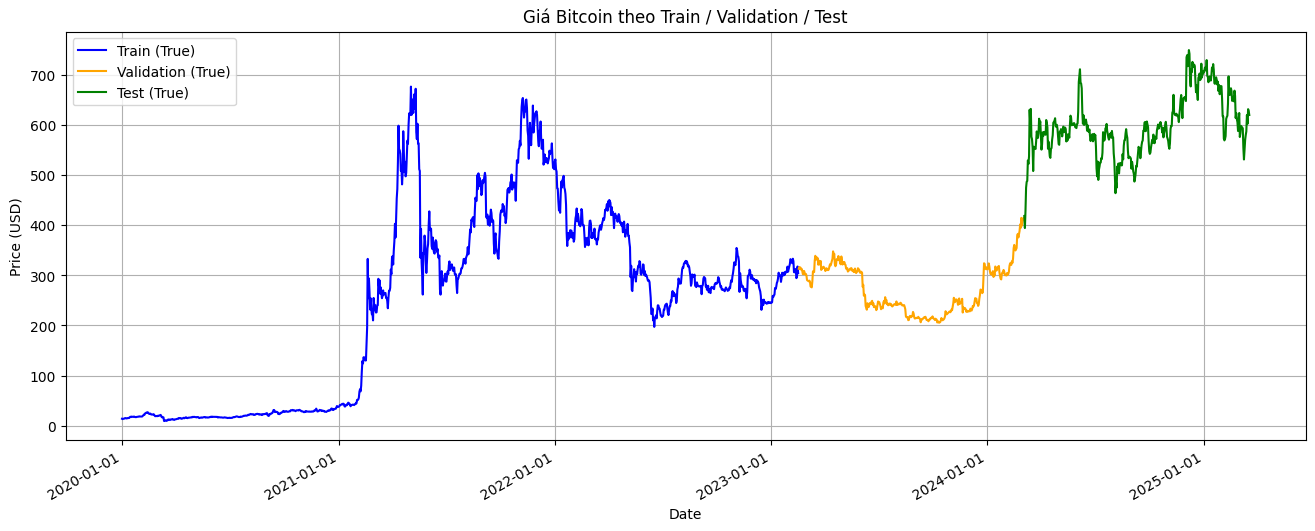

In [102]:
# 1. Tạo một Series đầy đủ từ 3 phần
full_prices = pd.concat([
    train_df['Price'],
    val_df['Price'],
    test_df['Price']
])

# 2. Tạo đồ thị, vẽ lần lượt từng phần với màu khác nhau
plt.figure(figsize=(16,6))

plt.plot(train_df.index, train_df['Price'], label='Train (True)', color='blue')
plt.plot(val_df.index, val_df['Price'], label='Validation (True)', color='orange')
plt.plot(test_df.index, test_df['Price'], label='Test (True)', color='green')

# 3. Định dạng trục x ngày tháng
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.title('Giá Bitcoin theo Train / Validation / Test')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
# 2. Chọn cột cần thiết và scale
feature_cols = ['Open', 'High', 'Low', 'Vol.', 'Price']
train_df = train_df[feature_cols]
val_df = val_df[feature_cols]
test_df = test_df[feature_cols]

In [104]:
# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
# fit: tính trung bình và độ lệch chuẩn từ train_df.
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)       # chỉ áp dụng transform ở tập val và tập test tránh bị rò rỉ dữ liệu
test_scaled = scaler.transform(test_df)


In [105]:
# Chuyển kết quả từ ndarray về DataFrame với tên cột giống feature_cols ban đầu để dễ xử lý về sau.
train_scaled_df = pd.DataFrame(train_scaled, columns=feature_cols)
val_scaled_df = pd.DataFrame(val_scaled, columns=feature_cols)
test_scaled_df = pd.DataFrame(test_scaled, columns=feature_cols)

In [106]:
def create_sequences(data, time_steps=100):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 100
X_train, y_train = create_sequences(train_scaled, time_steps)
X_val,   y_val   = create_sequences(val_scaled,   time_steps)
X_test,  y_test  = create_sequences(test_scaled,  time_steps)

In [107]:
# 5. Flatten input từ (samples, time_steps, features) → (samples, time_steps * features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# # 6. Tìm tham số tốt nhất thủ công qua tập validation
# Khởi tạo mô hình

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_flat.shape[1],), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_flat + np.random.normal(0, 0.5, X_train_flat.shape),  # thêm nhiễu vào train
    y_train,
    validation_data=(X_val_flat, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.0383 - mae: 0.9716 - val_loss: 0.2999 - val_mae: 0.0870
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7621 - mae: 0.5283 - val_loss: 0.2994 - val_mae: 0.0996
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5749 - mae: 0.4074 - val_loss: 0.2917 - val_mae: 0.0817
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4777 - mae: 0.3311 - val_loss: 0.2885 - val_mae: 0.0772
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4402 - mae: 0.3042 - val_loss: 0.2877 - val_mae: 0.0843
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4193 - mae: 0.2936 - val_loss: 0.2851 - val_mae: 0.0831
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4018 - mae: 0.2785 - val_loss: 0.2836 - val_mae: 0.0885
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3791 - mae: 0.2500 - val_loss: 0.2793 - val_mae: 0.0815
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.36

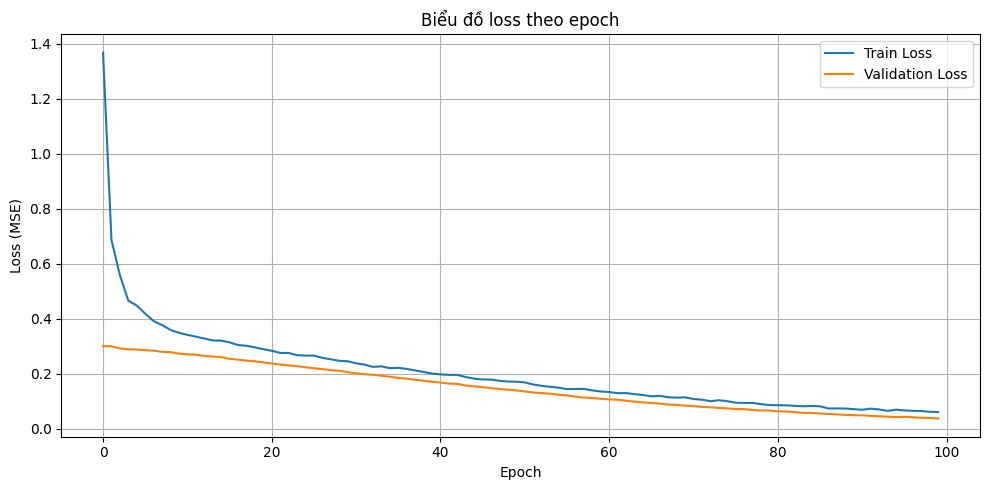

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Biểu đồ loss theo epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
# 7.Dự đoán
y_pred_val = model.predict(X_val_flat)
y_pred_test = model.predict(X_test_flat)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [110]:
# 8. Inverse transform giá
# Khôi phục về giá trị gốc để dễ hiểu và so sánh
price_scaler = StandardScaler()
price_scaler.fit(train_df[['Price']])
y_pred_val_original = price_scaler.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
y_pred_test_original = price_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

In [111]:
# Tính MAPE thủ công
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Biến y_test về giá gốc
y_val_original = price_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# bước đánh giá hiệu năng mô hình dự đoán giá (như SVR) bằng cách sử dụng các chỉ số đánh giá phổ biến, sau khi đã khôi phục giá trị gốc từ dữ liệu chuẩn hóa
# Tính các chỉ số đánh giá
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
mae = mean_absolute_error(y_test_original, y_pred_test_original)
r2 = r2_score(y_test_original, y_pred_test_original)
mape = mean_absolute_percentage_error(y_test_original, y_pred_test_original)

# In kết quả
print("=== Đánh giá mô hình trên tập Test ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

=== Đánh giá mô hình trên tập Test ===
RMSE: 28.53
MAE: 23.46
R²: 0.7942
MAPE: 3.85%


In [112]:
# 9. Dự đoán tương lai 30/60/90 ngày
# last_sequence = test_scaled_df[feature_cols[:-1]].iloc[-100:].values
last_sequence = test_scaled_df[feature_cols].iloc[-100:].values  # giữ nguyên đủ số đặc trưng

future_inputs = last_sequence.copy()
all_predictions = []

price_index = feature_cols.index('Price')  # xác định vị trí cột Price

for _ in range(90):
    input_flat = future_inputs.reshape(1, -1)
    pred_scaled = model.predict(input_flat)[0]
    all_predictions.append(pred_scaled)

    # Tạo vector tiếp theo bằng cách cập nhật giá trị Price
    next_step = future_inputs[-1].copy()             # copy bước cuối cùng
    next_step[price_index] = pred_scaled             # thay giá trị Price
    next_input = np.append(future_inputs[1:], [next_step], axis=0)  # cập nhật chuỗi
    future_inputs = next_input



future_days = [30, 60, 90]
future_predictions_scaled = {}
for days in future_days:
    scaled_preds = np.array(all_predictions[:days]).reshape(-1, 1)
    future_predictions_scaled[days] = price_scaler.inverse_transform(scaled_preds).flatten()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-112-c21765e9f1c7>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_step[price_index] = pred_scaled             # thay giá trị Price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

In [113]:
# Tạo ngày
last_date = test_df.index[-1]
dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

# Lấy giá trị dự đoán từ all_predictions (dự đoán 90 ngày đã chạy sẵn)
pred_30 = price_scaler.inverse_transform(np.array(all_predictions[:30]).reshape(-1, 1)).flatten()
pred_60 = price_scaler.inverse_transform(np.array(all_predictions[:60]).reshape(-1, 1)).flatten()
pred_90 = price_scaler.inverse_transform(np.array(all_predictions[:90]).reshape(-1, 1)).flatten()


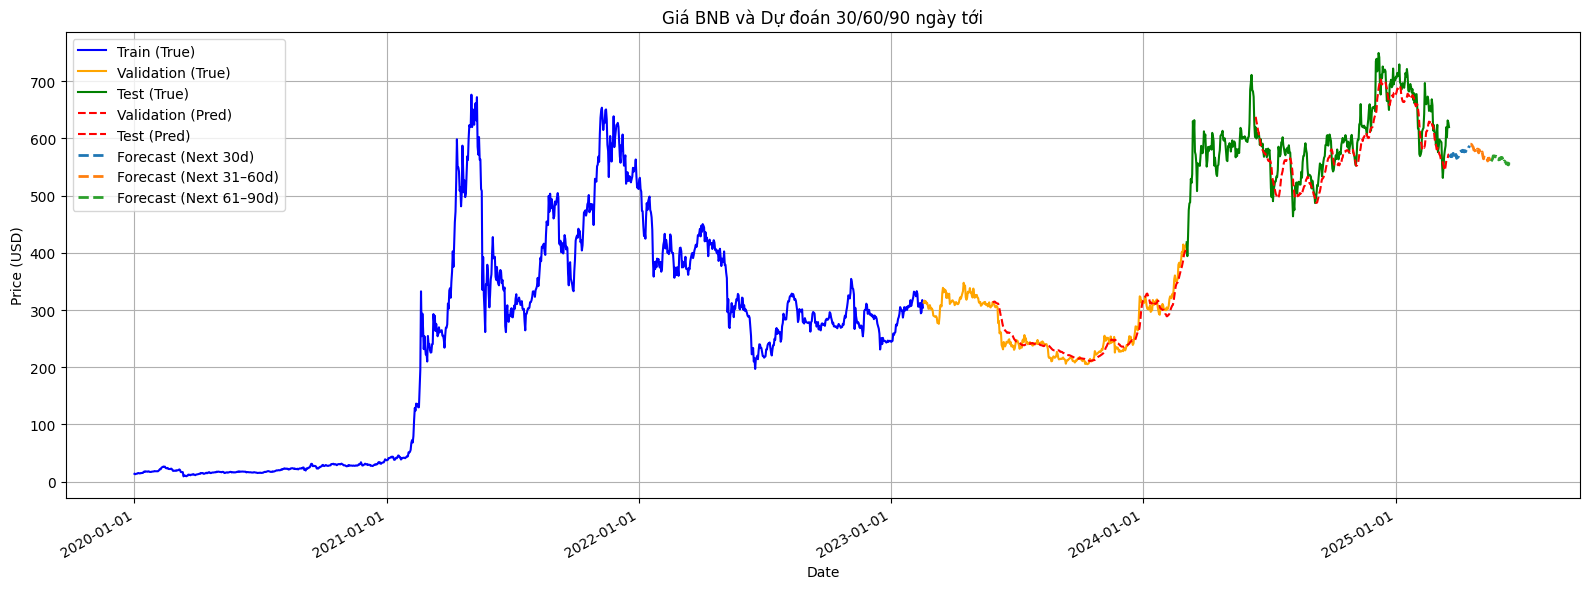

In [114]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tạo ngày cho val/test (do mất time_steps)
dates_val = val_df.index[time_steps:]
dates_test = test_df.index[time_steps:]

plt.figure(figsize=(16, 6))

# --- Vẽ dữ liệu thật ---
plt.plot(train_df.index, train_df['Price'], label='Train (True)', color='blue')
plt.plot(val_df.index, val_df['Price'], label='Validation (True)', color='orange')
plt.plot(test_df.index, test_df['Price'], label='Test (True)', color='green')

# --- Vẽ dự đoán trên val/test ---
plt.plot(dates_val, y_pred_val_original, '--', label='Validation (Pred)', color='red')
plt.plot(dates_test, y_pred_test_original, '--', label='Test (Pred)', color='red')


# Giả sử bạn đã có biến ngày cuối cùng trong tập test
last_date = test_df.index[-1]


# --- Vẽ dự đoán tương lai ---
# Dự đoán 30 ngày
plt.plot(dates_30, pred_30, '--', color='tab:blue', label='Forecast (Next 30d)', linewidth=2)

# Dự đoán ngày 31–60 (chỉ vẽ phần chưa vẽ)
plt.plot(dates_60[30:], pred_60[30:], '--', color='tab:orange', label='Forecast (Next 31–60d)', linewidth=2)

# Dự đoán ngày 61–90 (chỉ vẽ phần chưa vẽ)
plt.plot(dates_90[60:], pred_90[60:], '--', color='tab:green', label='Forecast (Next 61–90d)', linewidth=2)

# --- Định dạng trục ngày ---
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# --- Thêm thông tin biểu đồ ---
plt.title('Giá BNB và Dự đoán 30/60/90 ngày tới')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
